## Imports and Grab Data

In [1]:
from utils.notebook_2_utils import * 
import utils.notebook_2_utils as utils

training_df = pd.read_csv("data/training.csv")#.iloc[:100]
lookup_df = pd.read_csv("data/IdLookupTable.csv")
training_df.fillna(method = 'ffill',inplace = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
len(training_df)

7049

In [3]:
7049*30

211470

In [4]:
# Idlookup=pd.read_csv('data/IdLookupTable.csv')


# CUTOFFF

In [5]:
train_X, train_Y, val_X, val_Y = create_train_test_sets_nchw(training_df, normalize=True)

## ResNet Model
* Input shape:  64, 1, 96, 96 (nchw)
* Output shape: 64, 30 (nc)


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
import torch.nn.functional as F

### Model Definition

In [7]:
resnet = models.resnet18(pretrained=True)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
resnet.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## Control Panel

In [9]:
EPOCHS = 40
LEARNING_RATE = .02
BATCH_SIZE = 32


loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=LEARNING_RATE)





## Replace first and Last layers
* my input shape [32, 1, 96, 96] (NCHW) channels first

In [10]:
# freeze all layers
# for param in resnet.parameters():
#     param.requires_grad = False

# replace last layer
resnet.fc = nn.Linear(512, 30) # 30 is the number of keypoints we want to predict

# relpace the first layer
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# move to GPU
resnet = resnet.to(device)


In [11]:
resnet.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [33]:
resnet

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### DataLoaders

In [12]:
torch.manual_seed(42)
from torch.utils.data import TensorDataset, DataLoader


# Put data to target device
train_X, train_Y = train_X.to(device), train_Y.to(device)
val_X, val_Y = val_X.to(device), val_Y.to(device)

train_dataset = TensorDataset(train_X, train_Y)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(val_X, val_Y)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([32, 1, 96, 96]) torch.Size([32, 30])


In [14]:
resnet = resnet.to(device)

preds = resnet(X_batch)

In [15]:
preds.shape

torch.Size([32, 30])

In [16]:
loss = loss_fn(preds, y_batch)
loss

tensor(0.8185, device='cuda:0', grad_fn=<MseLossBackward0>)

In [17]:
# Checking to make sure the right layers are frozen

print("batch norm 1: ")
for param in resnet.bn1.parameters():
    print(param.requires_grad)
    
print("CONV1: ")
for param in resnet.conv1.parameters():
    print(param.requires_grad)

print("fc: ")
for param in resnet.fc.parameters():
    print(param.requires_grad)


batch norm 1: 
True
True
CONV1: 
True
fc: 
True
True


In [18]:
y_batch.shape

torch.Size([32, 30])

In [19]:
loss_fn(preds, y_batch)

tensor(0.8185, device='cuda:0', grad_fn=<MseLossBackward0>)

## Training Loop 

In [20]:
for epoch in range(EPOCHS):
    ### Training mode 
    resnet.train()

    
    for X_batch, y_batch in train_dataloader:
        # 1. Forward pass (model outputs raw logits)
        y_logits = resnet(X_batch)
        
        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_batch)
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backwards
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
    
    
    resnet.eval()
    with torch.inference_mode():
        for X_batch, y_batch in test_dataloader:
            test_logits = resnet(X_batch)
            test_loss = loss_fn(test_logits, y_batch)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.18601 | Test Loss: 0.34559
Epoch: 10 | Loss: 0.00147 | Test Loss: 0.00212
Epoch: 20 | Loss: 0.00144 | Test Loss: 0.00079
Epoch: 30 | Loss: 0.00083 | Test Loss: 0.00037


In [21]:
preds = resnet(val_X)

In [22]:
preds.shape

torch.Size([1409, 30])

In [23]:
val_Y.shape

torch.Size([1409, 30])

In [24]:
loss_fn(preds.to(device), val_Y.to(device))

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)

In [25]:
val_X.shape, preds.shape, val_Y.shape

(torch.Size([1409, 1, 96, 96]), torch.Size([1409, 30]), torch.Size([1409, 30]))

In [26]:
preds[0][1]

tensor(0.3906, device='cuda:0', grad_fn=<SelectBackward0>)

In [27]:
val_X[1].shape, val_X[1][0].shape

(torch.Size([1, 96, 96]), torch.Size([96, 96]))

In [28]:
def show_pred(X, preds, actual, index, point):
    plt.imshow(X[index][0],cmap='gray')

    plt.scatter(96* preds[index][point],96* preds[index][point + 1] ,c='r', marker='s', s=60, alpha=.5)
    plt.scatter(96*actual[index][point],96* actual[index][point+1],c='g', marker='s', s=60, alpha=.5)

    plt.legend(['predicted','actual'])
    


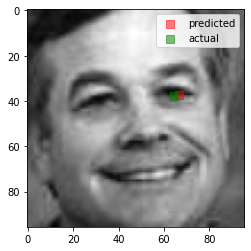

In [29]:
show_pred(val_X.to("cpu"), preds.to("cpu").detach().numpy(), val_Y.to("cpu").detach().numpy(), 0, 0)

In [30]:
preds[0][0], preds[0][1]

(tensor(0.6953, device='cuda:0', grad_fn=<SelectBackward0>),
 tensor(0.3906, device='cuda:0', grad_fn=<SelectBackward0>))

In [31]:
val_Y[0][0], val_Y[0][1]

(tensor(0.6736, device='cuda:0'), tensor(0.3915, device='cuda:0'))

In [32]:
val_X[0][0]

tensor([[0.1843, 0.1529, 0.1255,  ..., 0.2902, 0.2980, 0.3137],
        [0.1725, 0.1529, 0.1333,  ..., 0.2863, 0.2941, 0.3059],
        [0.1686, 0.1608, 0.1451,  ..., 0.2863, 0.2941, 0.2980],
        ...,
        [0.2902, 0.2902, 0.2902,  ..., 0.2314, 0.2353, 0.2392],
        [0.2980, 0.2902, 0.2863,  ..., 0.2353, 0.2392, 0.2471],
        [0.3059, 0.2941, 0.2824,  ..., 0.2431, 0.2431, 0.2471]],
       device='cuda:0')